In [1]:
import os, sys
sys.path += [os.path.dirname('../scripts/')]

In [2]:
import pandas as pd
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
model_ckpt = 'CL_expression_after_valaro_z64_bs512'

In [5]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('../outputs/' + model_ckpt + '/model')
model = ViTForImageClassification.from_pretrained('../outputs/' + model_ckpt + '/model').to(device)

/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:
from torchaffectnet import AffectNetDataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor(),
    normalize,
])
valaro_dataset = AffectNetDataset('../../Affectnet/validation.csv',
                                  '../../Affectnet/Manually_Annotated/Manually_Annotated_Images/',
                                  transform=transform,
                                  mode='valence-arousal')
emotion_dataset = AffectNetDataset('../../Affectnet/validation.csv',
                                   '../../Affectnet/Manually_Annotated/Manually_Annotated_Images/',
                                   transform=transform,
                                   mode='classification')

In [7]:
from tqdm import tqdm
import numpy as np

def CLS_tokens(model, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device),
                          output_hidden_states=True).hidden_states[-1][0, 0, :]
        tokens.append(token.cpu())
        labels.append(label)
    tokens, labels = torch.stack(tokens).squeeze(), torch.stack(labels)
    data = np.column_stack((tokens, labels))
    np.savetxt(os.path.join(f'data/{model_ckpt}'+"token_and_valaro.csv"), data, delimiter=',')
    return tokens, labels


In [11]:
from typing import Literal
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from umap.umap_ import UMAP
from sklearn.manifold import MDS

class MinMaxScaler():
    def __init__(self, min_, max_, input_min, input_max):
        self.min = min_
        self.max = max_
        self.in_min = input_min
        self.in_max = input_max
    
    def transform(self, input):
        return (input - self.in_min) / (self.in_max - self.in_min) * (self.max - self.min) + self.min

def plot_tokens_valence(tokens, targets, n_neighbors, random_seed, method: Literal['umap', 'mds', 'csv'] = 'umap', csv_name: str = None):
    if method == 'umap':
        umap = UMAP(n_neighbors=n_neighbors, random_state=random_seed)
        zs = np.array(umap.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/{model_ckpt}'+"valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'mds':
        mds = MDS(n_components=2, random_state=random_seed, n_init=2)
        tokens = F.normalize(tokens, dim=0)
        zs = np.array(mds.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/{model_ckpt}'+"valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'csv':
        df = pd.read_csv(csv_name, header=None)
        cols = df.columns
        zs = df[cols[:2]].values
        targets = df[cols[2:]].values
    x = zs[:, 0]
    y = zs[:, 1]
    valence = targets[:, 0]
    arousal = targets[:, 1]
    # scaler = MinMaxScaler(25, 0.5, -1, 1)
    # size = scaler.transform(arousal)
    # alpha = (arousal - arousal.min()) / (arousal.max() - arousal.min())
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    ax.set_box_aspect(1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1,1)

    mp = ax.scatter(x, y,
                    alpha=0.6,
                    c=valence,
                    # c=arousal,
                    cmap='turbo',
                    vmin=-1,
                    vmax=1,
                    # s=size,
                    s=5,
                    edgecolors=None)
    color_bar = fig.colorbar(mp, ax=ax)
    color_bar.set_label('valence')
    return fig, None

def plot_tokens_arousal(tokens, targets, n_neighbors, random_seed, method: Literal['umap', 'mds', 'csv'] = 'umap', csv_name: str = None):
    if method == 'umap':
        umap = UMAP(n_neighbors=n_neighbors, random_state=random_seed)
        zs = np.array(umap.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/{model_ckpt}'+"valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'mds':
        mds = MDS(n_components=2, random_state=random_seed, n_init=2)
        tokens = F.normalize(tokens, dim=0)
        zs = np.array(mds.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/{model_ckpt}'+"valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'csv':
        df = pd.read_csv(csv_name, header=None)
        cols = df.columns
        zs = df[cols[:2]].values
        targets = df[cols[2:]].values
    x = zs[:, 0]
    y = zs[:, 1]
    valence = targets[:, 0]
    arousal = targets[:, 1]
    # scaler = MinMaxScaler(25, 0.5, -1, 1)
    # size = scaler.transform(arousal)
    # alpha = (arousal - arousal.min()) / (arousal.max() - arousal.min())
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    ax.set_box_aspect(1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1,1)

    mp = ax.scatter(x, y,
                    alpha=0.6,
                    c=arousal,
                    # c=arousal,
                    cmap='turbo',
                    vmin=-1,
                    vmax=1,
                    # s=size,
                    s=5,
                    edgecolors=None)
    color_bar = fig.colorbar(mp, ax=ax)
    # color_bar.set_label('valence')
    color_bar.set_label('arousal')
    return fig, None

In [10]:
CLS_tokens(model, valaro_dataset, device)

100%|██████████| 4000/4000 [02:38<00:00, 25.24it/s]


(tensor([[-8.3402e-01,  3.0574e+00,  3.0306e+00,  ...,  2.8841e+00,
          -7.1100e+00, -3.3908e+00],
         [-8.8063e+00, -2.2155e+00,  5.5418e-01,  ...,  5.7660e+00,
          -8.1748e+00,  9.8637e-01],
         [-1.5804e+00,  4.7954e+00, -4.4769e+00,  ..., -1.1805e+00,
           1.0284e+00,  2.1708e+00],
         ...,
         [-1.6551e+01,  8.5413e-03,  1.7217e+00,  ...,  5.1189e+00,
          -2.8578e+00,  5.5714e+00],
         [-5.8342e-01,  2.8162e+00, -5.0283e+00,  ...,  2.5416e+00,
           1.7472e+00,  8.0130e-01],
         [-1.3023e+01, -8.9049e+00,  2.7420e+00,  ...,  1.1004e+00,
          -2.1099e+00, -3.5011e+00]]),
 tensor([[-0.6533,  0.6533],
         [-0.1768, -0.0776],
         [-0.3678,  0.1839],
         ...,
         [-0.3016,  0.2381],
         [-0.2758,  0.5904],
         [-0.6678, -0.2468]]))

100%|██████████| 4000/4000 [00:54<00:00, 73.69it/s]
/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


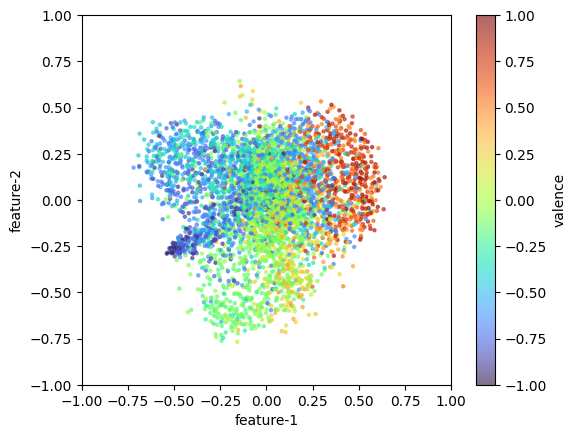

In [12]:
features, labels = CLS_tokens(model, valaro_dataset, device)
# fig, legend = plot_tokens_valence(None, None, 20, 0, 'csv', f'data/{model_ckpt}valaro.csv')
fig, legend = plot_tokens_valence(features, labels, 20, 0, 'mds', None)

In [13]:
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'valence'+'.svg'), bbox_inches='tight')
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'valence'+'.png'), bbox_inches='tight')

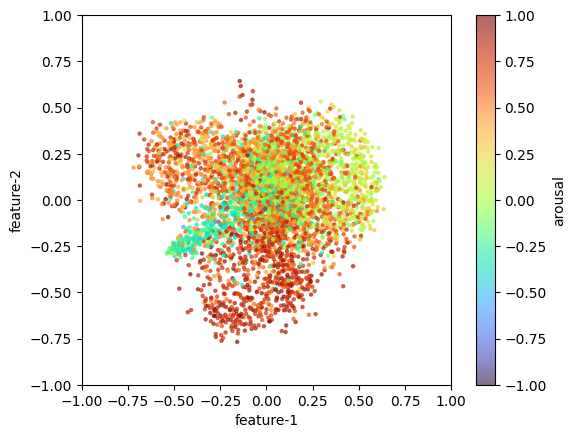

In [14]:
fig, legend = plot_tokens_arousal(None, None, 20, 0, 'csv', f'data/{model_ckpt}valaro.csv')

In [15]:
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'arousal'+'.svg'), bbox_inches='tight')
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'arousal'+'.png'), bbox_inches='tight')